In [218]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics, tree, svm, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,train_test_split,LeaveOneOut
from sklearn.naive_bayes import MultinomialNB
from statistics import mean
from data_load import retrieve_prediction_labels


INV_INDEX_PROGRAM = {
                    0:'Biomedical Engineering', 
                    1:'Chemical Engineering', 
                    2:'Civil Engineering', 
                    3:'Computer Engineering' , 
                    4:'Electrical Engineering', 
                    5:'Environmental Engineering' , 
                    6:'Geological Engineering' , 
                    7:'Management Engineering' , 
                    8:'Mechanical Engineering' , 
                    9:'Mechatronics Engineering' , 
                    10:'Nanotechnology Engineering', 
                    11:'Software Engineering' , 
                    12:'Systems Design Engineering'
                    }


In [211]:
# Methods For Needed for New Scoring Methodology
def retrieve_prediction_labels(model,prediction):
    # returns a dictionary for each label and their probability in the prediction
    labels = model.classes_
    results = prediction[0]
    results_dict = {}
    for i in range(len(results)):
        results_dict[str(labels[i])] = np.round(results[i],4)
    return results_dict

def sort_probability_dict(p_df):
    ordered_probabilties = sorted(p_df.values(),reverse=True)
    ordered_programs = sorted(p_df, key=p_df.get,reverse=True)
    return [p_df, ordered_probabilties, ordered_programs]

def get_mclass_accuracy(temp_model_name,model,test_array,test_actual):
    test_pred = []
    for i in range(len(test_array)):
        test_pred.append(model.predict([test_array[i]]))
    accuracy = metrics.accuracy_score(test_pred,test_actual)
    return accuracy

def get_mclass_topN(temp_model_name,model,test_array,test_actual,topN):
    topN_scores = []
    for i in range(len(test_array)):
        prediction = model.predict_proba([test_array[i]])
        probs = sort_probability_dict(retrieve_prediction_labels(model,prediction))[2][:topN]
        if str(test_actual[i]) in probs:
            topN_scores.append(1)
        else:
            topN_scores.append(0)
    return mean(topN_scores)

def get_mclass_t3(temp_model_name,model,test_array,test_actual):
    t3_scores = []
    for i in range(len(test_array)):
        prediction = model.predict_proba([test_array[i]])
        probs = sort_probability_dict(retrieve_prediction_labels(model,prediction))[2][:3]
        try:
            t3 = (1/(probs.index(str(test_actual[i])+1)))
        except:
            t3 = 0
        t3_scores.append(t3)
    return mean(t3_scores)

def get_mclass_rr(temp_model_name,model,test_array,test_actual):
    rr_scores = []
    for i in range(len(test_array)):
        prediction = model.predict_proba([test_array[i]])
        probs = sort_probability_dict(retrieve_prediction_labels(model,prediction))[2]
        try:
            rr = (1/(probs.index(str(test_actual[i])+1)))
        except:
            rr = 0
        rr_scores.append(rr)
    return mean(rr_scores)

In [212]:
READ_HEADERS = {
            'What program are you in currently?':'program',
            'Are you happy with your program?':'happy',
            'What is your gender? Your answer will only be used for data collection purposes.':'gender',
            '1. What field interests you the most?':'field_interest',
            '2. I would like to have been part of the team that was responsible for:':'team_responsible',
            '3. Who would be your dream professor?':'dream_professor',
            '4. I would enjoy working...':'work_setting',
            '5. An ideal outfit to wear to work would be:':'work_outfit',
            '6. When you start work, ideally you would want to...':'start_work',
            '7. I would rather design something that...':'design_something',
            '8. I would rather analyze...':'analyze_something',
            '9. I would rather gather information for solving a problem...':'solve_problem',
            '10. I prefer to...':'prefer_to',
            '11. I would rather work as part of a...':'work_partof',
            '12. When working on a project would you rather':'on_project',
            '13. What cause do you care about the most?':'care_most',
            '14. When setting goals for yourself you find yourself thinking about...':'goals',
            '15. You are most likely to eavesdrop in a conversation regarding':'eavesdrop',
            '16. What subject would you like to develop your skills in?':'develop_skills',
            '17. In an ideal setting, you are working with:':'working_with',
            '18. Would you prefer to be the leader on a team?':'leader'
        }

In [213]:
# Loading and Preparing old team's data

old_data = 'data/old_all.csv'
training = 'data/old_training.csv'
testing = 'data/old_testing.csv'

old_data = pd.read_csv(old_data,dtype=str)
training = pd.read_csv(training,dtype=str)
testing = pd.read_csv(testing,dtype=str)

old_data = old_data.rename(index=str,columns = READ_HEADERS)
training = training.rename(index=str,columns = READ_HEADERS)
testing = testing.rename(index=str,columns = READ_HEADERS)

loo_old_data = old_data[old_data.happy == 'Yes']

loo_old_data = loo_old_data.drop(loo_old_data.columns[[0,2,3]], axis=1)
training = training.drop(training.columns[[0,2,3,4]], axis=1)
gender_testing = testing.copy()
gender_testing = gender_testing.drop(testing.columns[[0,3,4]], axis=1)

In [214]:
# Preparing to run their best Naive Bayes Model
selected_features = [
            'program',
            'field_interest',
            'team_responsible',
            'start_work',
            'design_something',
            'work_partof',
            'on_project',
            'care_most',
            'eavesdrop',
            'working_with'
            ]

training = training[selected_features]
testing = testing[selected_features]

df = loo_old_data[selected_features]
encoded_dict_list = []
for col in selected_features:
    keys = df[col].unique()
    le = preprocessing.LabelEncoder()
    le.fit(list(keys))
    df[col] = le.transform(list(df[col]))
    vals = df[col].unique()
    keys = list(le.inverse_transform(vals))
    cd = dict(zip(keys,vals))
    row = {str(col):cd}
    encoded_dict_list.append(row)
loo_old_data  = df

df = training
encoded_dict_list = []
for col in selected_features:
    keys = df[col].unique()
    le = preprocessing.LabelEncoder()
    le.fit(list(keys))
    df[col] = le.transform(list(df[col]))
    vals = df[col].unique()
    keys = list(le.inverse_transform(vals))
    cd = dict(zip(keys,vals))
    row = {str(col):cd}
    encoded_dict_list.append(row)
training  = df

df = testing
encoded_dict_list = []
for col in selected_features:
    keys = df[col].unique()
    le = preprocessing.LabelEncoder()
    le.fit(list(keys))
    df[col] = le.transform(list(df[col]))
    vals = df[col].unique()
    keys = list(le.inverse_transform(vals))
    cd = dict(zip(keys,vals))
    row = {str(col):cd}
    encoded_dict_list.append(row)

testing = df
PARENT_TESTING = testing.copy()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [215]:
# Building Old Winning Model
model_name = 'old_winner'
temp_model_name = model_name

x_df = training.drop(axis=1,columns=["program"])
y_df = training["program"]

X = np.array(x_df) # convert dataframe into np array
Y = np.array(y_df) # convert dataframe into np array

mnb = MultinomialNB()
model = mnb.fit(X, Y) # fit the model using training data


In [216]:
# Scoring Old Winning Model with Updated Scoring Methodology
test_array = np.array(testing.drop(axis=1,columns=["program"]))
test_actual = np.array(testing["program"])
testing = testing.drop(axis=1,columns=["program"])

In [217]:
prediction = model.predict_proba([test_array[3]])
print(prediction)

[[0.12135714 0.12273466 0.00291558 0.03819783 0.02400742 0.01866157
  0.00163707 0.1763612  0.03024624 0.04020665 0.21633034 0.15487591
  0.05246839]]


In [151]:
scoring_dictionary = {}
mclass_t3 = get_mclass_t3(temp_model_name,model,test_array,test_actual)
mclass_RR = get_mclass_rr(temp_model_name,model,test_array,test_actual)
mclass_accuracy = get_mclass_accuracy(temp_model_name,model,test_array,test_actual)
mclass_top2 = get_mclass_topN(temp_model_name,model,test_array,test_actual,2)
mclass_top3 = get_mclass_topN(temp_model_name,model,test_array,test_actual,3)
mclass_top4 = get_mclass_topN(temp_model_name,model,test_array,test_actual,4)
mclass_top5 = get_mclass_topN(temp_model_name,model,test_array,test_actual,5)
mclass_top6 = get_mclass_topN(temp_model_name,model,test_array,test_actual,6)
mclass_top7 = get_mclass_topN(temp_model_name,model,test_array,test_actual,7)
mclass_top8 = get_mclass_topN(temp_model_name,model,test_array,test_actual,8)
mclass_top9 = get_mclass_topN(temp_model_name,model,test_array,test_actual,9)
mclass_top10 = get_mclass_topN(temp_model_name,model,test_array,test_actual,10)
mclass_top11 = get_mclass_topN(temp_model_name,model,test_array,test_actual,11)
mclass_top12 = get_mclass_topN(temp_model_name,model,test_array,test_actual,12)
mclass_top13 = get_mclass_topN(temp_model_name,model,test_array,test_actual,13)
mclass_top14 = get_mclass_topN(temp_model_name,model,test_array,test_actual,14)
mclass_top15 = get_mclass_topN(temp_model_name,model,test_array,test_actual,15)

scoring_dictionary = {'t3':mclass_t3,
                     'RR':mclass_RR,
                     'accuracy':mclass_accuracy,
                     'top2':mclass_top2,
                     'top3':mclass_top3,
                     'top4':mclass_top4,
                     'top5':mclass_top5,
                     'top6':mclass_top6,
                     'top7':mclass_top7,
                     'top8':mclass_top8,
                     'top9':mclass_top9,
                     'top10':mclass_top10,
                     'top11':mclass_top11,
                     'top12':mclass_top12,
                     'top13':mclass_top13,
                     'top14':mclass_top14,
                     'top15':mclass_top15
                    }



# Heat Map for Confusion Matrix

In [156]:
test_data = gender_testing.copy()
predictions = list(model.predict(testing))
for i in range(0, len(predictions)):
    predictions[i] = INV_INDEX_PROGRAM[predictions[i]]
test_data['predicted_program'] = predictions

                  program  Gender        field_interest team_responsible  \
0  Biomedical Engineering  Female  Software Development        The Robot   
1  Biomedical Engineering    Male  Software Development       Penicillin   
2    Chemical Engineering  Female              Research       Penicillin   
3    Chemical Engineering    Male         Manufacturing       Penicillin   
4       Civil Engineering  Female         Manufacturing     The CN Tower   

                                     dream_professor  \
0  Warren Buffett, Billionaire American Business Men   
1                        Elon Musk, Founder of Tesla   
2  Madam Marie Curie, Noble Price Winner for work...   
3                        Elon Musk, Founder of Tesla   
4                        Elon Musk, Founder of Tesla   

                  work_setting          work_outfit  \
0                 In an office     Extremely Casual   
1                 In an office     Extremely Casual   
2  In a manufacturing facility      Busin

In [174]:
print(test_data[['program','predicted_program']])

                       program           predicted_program
0       Biomedical Engineering        Software Engineering
1       Biomedical Engineering  Nanotechnology Engineering
2         Chemical Engineering  Nanotechnology Engineering
3         Chemical Engineering  Nanotechnology Engineering
4            Civil Engineering      Management Engineering
5            Civil Engineering           Civil Engineering
6         Computer Engineering        Software Engineering
7         Computer Engineering        Software Engineering
8       Electrical Engineering    Mechatronics Engineering
9       Electrical Engineering    Mechatronics Engineering
10   Environmental Engineering  Nanotechnology Engineering
11   Environmental Engineering           Civil Engineering
12      Geological Engineering      Mechanical Engineering
13      Geological Engineering           Civil Engineering
14      Management Engineering        Software Engineering
15      Management Engineering        Software Engineeri

In [179]:
output = {}

for i in range(0,len(test_data)):
    try:
        program_count = output[test_data.loc[str(i),'program']]
    except:
        program_count = {
                        'Biomedical Engineering-predicted': 0, 
                        'Chemical Engineering-predicted':0, 
                        'Civil Engineering-predicted': 0, 
                        'Computer Engineering-predicted': 0, 
                        'Electrical Engineering-predicted': 0, 
                        'Environmental Engineering-predicted': 0, 
                        'Geological Engineering-predicted': 0, 
                        'Management Engineering-predicted': 0, 
                        'Mechanical Engineering-predicted': 0, 
                        'Mechatronics Engineering-predicted': 0, 
                        'Nanotechnology Engineering-predicted': 0, 
                        'Software Engineering-predicted': 0, 
                        'Systems Design Engineering-predicted': 0
                        }
    program_count[test_data.loc[str(i),'predicted_program']+'-predicted'] = program_count[test_data.loc[str(i),'predicted_program']+'-predicted'] + 1
    output[test_data.loc[str(i),'program']] = program_count

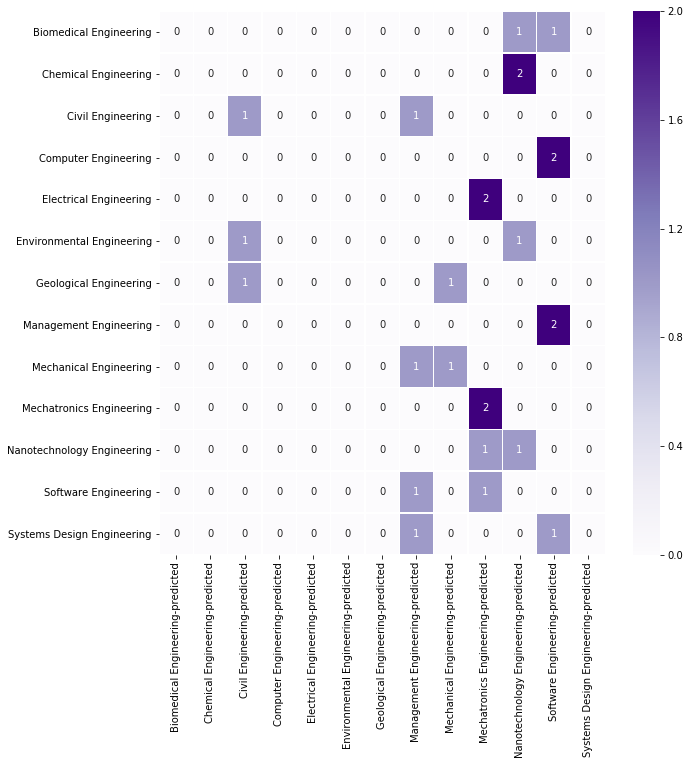

In [184]:
df = pd.DataFrame(output).T
df = df.reindex(sorted(df.columns), axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(df,cmap='Purples',annot=True,linewidth=0.5)

In [188]:
gender_data = gender_testing.copy()
print(gender_data)

                       program  Gender        field_interest team_responsible  \
0       Biomedical Engineering  Female  Software Development        The Robot   
1       Biomedical Engineering    Male  Software Development       Penicillin   
2         Chemical Engineering  Female              Research       Penicillin   
3         Chemical Engineering    Male         Manufacturing       Penicillin   
4            Civil Engineering  Female         Manufacturing     The CN Tower   
5            Civil Engineering    Male          Construction     The CN Tower   
6         Computer Engineering  Female  Software Development        The Robot   
7         Computer Engineering    Male  Software Development     The Internet   
8       Electrical Engineering  Female              Research     Solar Panels   
9       Electrical Engineering    Male              Research     The Internet   
10   Environmental Engineering  Female          Construction       Penicillin   
11   Environmental Engineeri

# Gender Bias

In [191]:
gender_data = gender_testing.copy()

gender_count = {'male':{'program':{},'predicted_program':{}},'female':{'program':{},'predicted_program':{}}}

for i in range(0,len(test_data)):
    if test_data.loc[str(i),'Gender'] == 'Male':
        gender_cols = gender_count['male']
        try:
            program_count = gender_cols['program']
            program_count[test_data.loc[str(i),'program']] = program_count[test_data.loc[str(i),'program']] + 1
        except:
            program_count = {
                            'Biomedical Engineering': 0, 
                            'Chemical Engineering': 0, 
                            'Civil Engineering': 0, 
                            'Computer Engineering': 0, 
                            'Electrical Engineering': 0, 
                            'Environmental Engineering': 0, 
                            'Geological Engineering': 0, 
                            'Management Engineering': 0, 
                            'Mechanical Engineering': 0, 
                            'Mechatronics Engineering': 0, 
                            'Nanotechnology Engineering': 0, 
                            'Software Engineering': 0, 
                            'Systems Design Engineering': 0
                            }
            program_count[test_data.loc[str(i),'program']] = 1
        try:
            predicted_count = gender_cols['predicted_program']
            predicted_count[test_data.loc[str(i),'predicted_program']] = predicted_count[test_data.loc[str(i),'predicted_program']] + 1
        except:
            predicted_count = {
                                'Biomedical Engineering': 0, 
                                'Chemical Engineering': 0, 
                                'Civil Engineering': 0, 
                                'Computer Engineering': 0, 
                                'Electrical Engineering': 0, 
                                'Environmental Engineering': 0, 
                                'Geological Engineering': 0, 
                                'Management Engineering': 0, 
                                'Mechanical Engineering': 0, 
                                'Mechatronics Engineering': 0, 
                                'Nanotechnology Engineering': 0, 
                                'Software Engineering': 0, 
                                'Systems Design Engineering': 0
                            }
            predicted_count[test_data.loc[str(i),'predicted_program']] = 1
        gender_cols['program'] = program_count
        gender_cols['predicted_program'] = predicted_count
        gender_count['male'] = gender_cols

    if test_data.loc[str(i),'Gender'] == 'Female':
        gender_cols = gender_count['female']
        try:
            program_count = gender_cols['program']
            program_count[test_data.loc[str(i),'program']] = program_count[test_data.loc[str(i),'program']] + 1
        except:
            program_count = {
                            'Biomedical Engineering': 0, 
                            'Chemical Engineering': 0, 
                            'Civil Engineering': 0, 
                            'Computer Engineering': 0, 
                            'Electrical Engineering': 0, 
                            'Environmental Engineering': 0, 
                            'Geological Engineering': 0, 
                            'Management Engineering': 0, 
                            'Mechanical Engineering': 0, 
                            'Mechatronics Engineering': 0, 
                            'Nanotechnology Engineering': 0, 
                            'Software Engineering': 0, 
                            'Systems Design Engineering': 0
                            }
            program_count[test_data.loc[str(i),'program']] = 1
        try:
            predicted_count = gender_cols['predicted_program']
            predicted_count[test_data.loc[str(i),'predicted_program']] = predicted_count[test_data.loc[str(i),'predicted_program']] + 1
        except:
            predicted_count = {
                                'Biomedical Engineering': 0, 
                                'Chemical Engineering': 0, 
                                'Civil Engineering': 0, 
                                'Computer Engineering': 0, 
                                'Electrical Engineering': 0, 
                                'Environmental Engineering': 0, 
                                'Geological Engineering': 0, 
                                'Management Engineering': 0, 
                                'Mechanical Engineering': 0, 
                                'Mechatronics Engineering': 0, 
                                'Nanotechnology Engineering': 0, 
                                'Software Engineering': 0, 
                                'Systems Design Engineering': 0
                            }
            predicted_count[test_data.loc[str(i),'predicted_program']] = 1
        gender_cols['program'] = program_count
        gender_cols['predicted_program'] = predicted_count
        gender_count['female'] = gender_cols
print(gender_count)

{'male': {'program': {'Biomedical Engineering': 1, 'Chemical Engineering': 1, 'Civil Engineering': 1, 'Computer Engineering': 1, 'Electrical Engineering': 1, 'Environmental Engineering': 1, 'Geological Engineering': 1, 'Management Engineering': 1, 'Mechanical Engineering': 1, 'Mechatronics Engineering': 1, 'Nanotechnology Engineering': 1, 'Software Engineering': 1, 'Systems Design Engineering': 1}, 'predicted_program': {'Biomedical Engineering': 0, 'Chemical Engineering': 0, 'Civil Engineering': 3, 'Computer Engineering': 0, 'Electrical Engineering': 0, 'Environmental Engineering': 0, 'Geological Engineering': 0, 'Management Engineering': 2, 'Mechanical Engineering': 1, 'Mechatronics Engineering': 3, 'Nanotechnology Engineering': 2, 'Software Engineering': 2, 'Systems Design Engineering': 0}}, 'female': {'program': {'Biomedical Engineering': 1, 'Chemical Engineering': 1, 'Civil Engineering': 1, 'Computer Engineering': 1, 'Electrical Engineering': 1, 'Environmental Engineering': 1, 'Geo

                                   program  predicted_program
Biomedical Engineering-female            1                  0
Biomedical Engineering-male              1                  0
Chemical Engineering-female              1                  0
Chemical Engineering-male                1                  0
Civil Engineering-female                 1                  0
Civil Engineering-male                   1                  3
Computer Engineering-female              1                  0
Computer Engineering-male                1                  0
Electrical Engineering-female            1                  0
Electrical Engineering-male              1                  0
Environmental Engineering-female         1                  0
Environmental Engineering-male           1                  0
Geological Engineering-female            1                  0
Geological Engineering-male              1                  0
Management Engineering-female            1                  2
Manageme

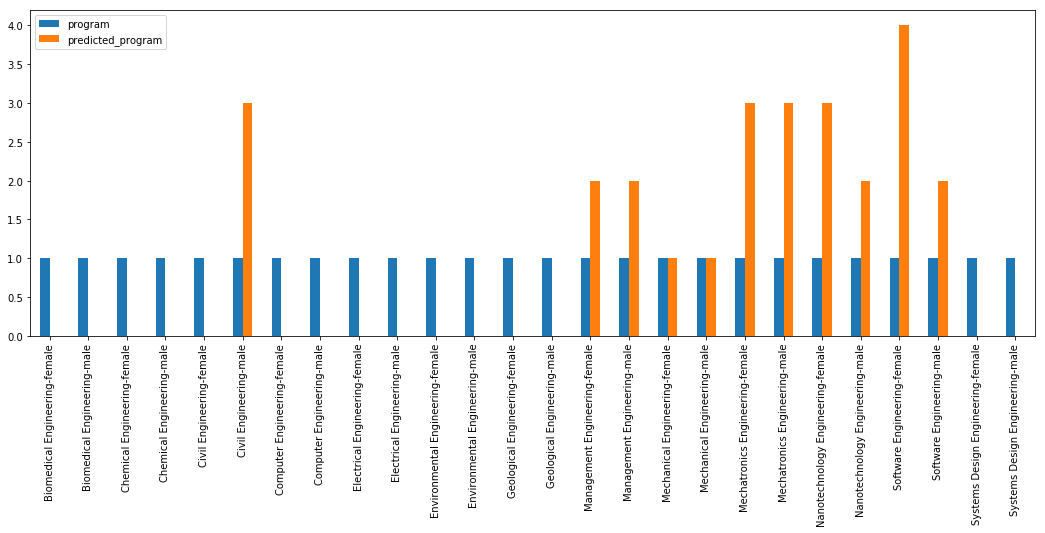

In [192]:
mdf = pd.DataFrame(gender_count['male'])
mdf.index += '-male'

fdf = pd.DataFrame(gender_count['female'])
fdf.index += '-female'

mdf = mdf.T
fdf = fdf.T

df = mdf.merge(fdf, left_index=True, right_index=True,how='left').T
df = df.sort_index()

print(df)
df.plot.bar(figsize=(18,6))
plt.show()

# Heat Map For Overall Probability

In [222]:
display_data = gender_testing.copy()
test_data =  PARENT_TESTING.copy().drop(axis=1,columns=["program"])

In [230]:
output = {
'Biomedical Engineering-actual': 0, 
'Chemical Engineering-actual':0, 
'Civil Engineering-actual': 0, 
'Computer Engineering-actual': 0, 
'Electrical Engineering-actual': 0, 
'Environmental Engineering-actual': 0, 
'Geological Engineering-actual': 0, 
'Management Engineering-actual': 0, 
'Mechanical Engineering-actual': 0, 
'Mechatronics Engineering-actual': 0, 
'Nanotechnology Engineering-actual': 0, 
'Software Engineering-actual': 0, 
'Systems Design Engineering-actual': 0
}

for i in range(0,len(display_data)):
    vector = np.asarray(test_data.loc[str(i),])
    scores = sort_probability_dict(retrieve_prediction_labels(model,prediction))[2][:15]
    print(scores)
    try:
        cumulative_scores = output[display_data.loc[str(i),'program']]
        for key in scores.keys():
            cumulative_scores[key] = cumulative_scores[key] + score[key]
    except:
        cumulative_scores = scores
        output[display_data.loc[str(i),'program']+'-actual'] = cumulative_scores
    
print(output)

['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'cive', 'bmed', 'elec']
['msci', 'env', 'nano', 'arch-e', 'arch', 'swe', 'mech', 'ce', 'geo', 'chem', 'civ

In [229]:
output = {
'Biomedical Engineering-actual': 0, 
'Chemical Engineering-actual':0, 
'Civil Engineering-actual': 0, 
'Computer Engineering-actual': 0, 
'Electrical Engineering-actual': 0, 
'Environmental Engineering-actual': 0, 
'Geological Engineering-actual': 0, 
'Management Engineering-actual': 0, 
'Mechanical Engineering-actual': 0, 
'Mechatronics Engineering-actual': 0, 
'Nanotechnology Engineering-actual': 0, 
'Software Engineering-actual': 0, 
'Systems Design Engineering-actual': 0
}

for i in range(0,len(display_data)):
    vector = np.asarray(test_data.loc[str(i),])
    scores = retrieve_prediction_labels(model,model.predict_proba([vector]))
    try:
        cumulative_scores = output[display_data.loc[str(i),'program']]
        for key in scores.keys():
            cumulative_scores[key] = cumulative_scores[key] + score[key]
    except:
        cumulative_scores = scores
        output[display_data.loc[str(i),'program']+'-actual'] = cumulative_scores
    
print(output)

{'Biomedical Engineering-actual': {'arch': 0.1523, 'arch-e': 0.0901, 'bmed': 0.0001, 'ce': 0.0493, 'chem': 0.0149, 'cive': 0.01, 'elec': 0.0003, 'env': 0.1595, 'geo': 0.0161, 'mech': 0.0205, 'msci': 0.2389, 'nano': 0.2072, 'swe': 0.0406}, 'Chemical Engineering-actual': {'arch': 0.1214, 'arch-e': 0.1227, 'bmed': 0.0029, 'ce': 0.0382, 'chem': 0.024, 'cive': 0.0187, 'elec': 0.0016, 'env': 0.1764, 'geo': 0.0302, 'mech': 0.0402, 'msci': 0.2163, 'nano': 0.1549, 'swe': 0.0525}, 'Civil Engineering-actual': {'arch': 0.0233, 'arch-e': 0.0158, 'bmed': 0.4555, 'ce': 0.0145, 'chem': 0.0334, 'cive': 0.0167, 'elec': 0.0278, 'env': 0.181, 'geo': 0.1031, 'mech': 0.0566, 'msci': 0.0127, 'nano': 0.0361, 'swe': 0.0234}, 'Computer Engineering-actual': {'arch': 0.0068, 'arch-e': 0.001, 'bmed': 0.0001, 'ce': 0.1831, 'chem': 0.0167, 'cive': 0.002, 'elec': 0.0002, 'env': 0.0819, 'geo': 0.0141, 'mech': 0.1685, 'msci': 0.0133, 'nano': 0.4501, 'swe': 0.0623}, 'Electrical Engineering-actual': {'arch': 0.0066, 'arc

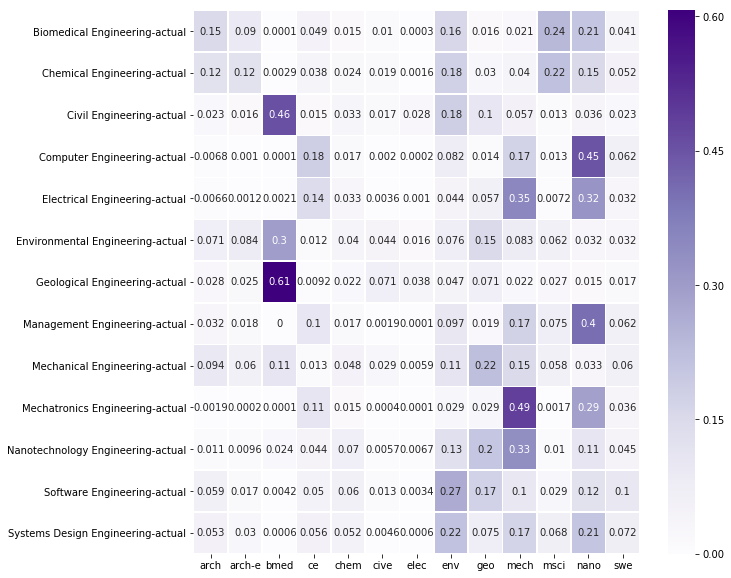

In [228]:
df = pd.DataFrame(output).T
df = df.reindex(sorted(df.columns), axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(df,cmap='Purples',annot=True,linewidth=0.5)

# LOO Accuracy Score

In [112]:
x_df = loo_old_data.drop(axis=1,columns=["program"])
y_df = loo_old_data["program"]

X = np.array(x_df) # convert dataframe into np array
y = np.array(y_df) # convert dataframe into np array

test_array = X
test_actual = y

test_pred = []
for i in range(len(test_array)):
    test_pred.append(model.predict([test_array[i]]))
    
accuracy = metrics.accuracy_score(test_pred,test_actual)
print("Accuracy Score")
print(accuracy)

loo = LeaveOneOut()
loo.get_n_splits(X)
accuracy = []

for train_index, test_index in loo.split(X):
    X_train, X_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index]) # use this for training the model\n",
    y_train, y_test = y[train_index].ravel(), y[test_index].ravel() # use this for testing the model\n",
    mnb = MultinomialNB()
    model = mnb.fit(X_train, y_train) # fit the model using training data
    accuracy.append(mnb.score(X_test, y_test))

mean_socre = np.array(accuracy).mean()
print("Leave One Out Score:")
print(mean_socre)


Accuracy Score
0.40556900726392253
Leave One Out Score:
0.3898305084745763


In [16]:
# Generating Heat Map for Program Bias